In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

# PyTorch device CUDA0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Increase font size to match Beamer template
plt.rcParams["font.size"] = 16
# Make background transparent
plt.rcParams["figure.facecolor"] = "none"


In [3]:
### Case 1: Homoskedastic noise

# Generate data

torch.manual_seed(42)
N = 100
x_lin = torch.linspace(-1, 1, N)

f = lambda x: 0.5 * x**2 + 0.25 * x**3

eps = torch.randn(N) * 0.2

y = f(x_lin) + eps

# Move to GPU
x_lin = x_lin.to(device)
y = y.to(device)


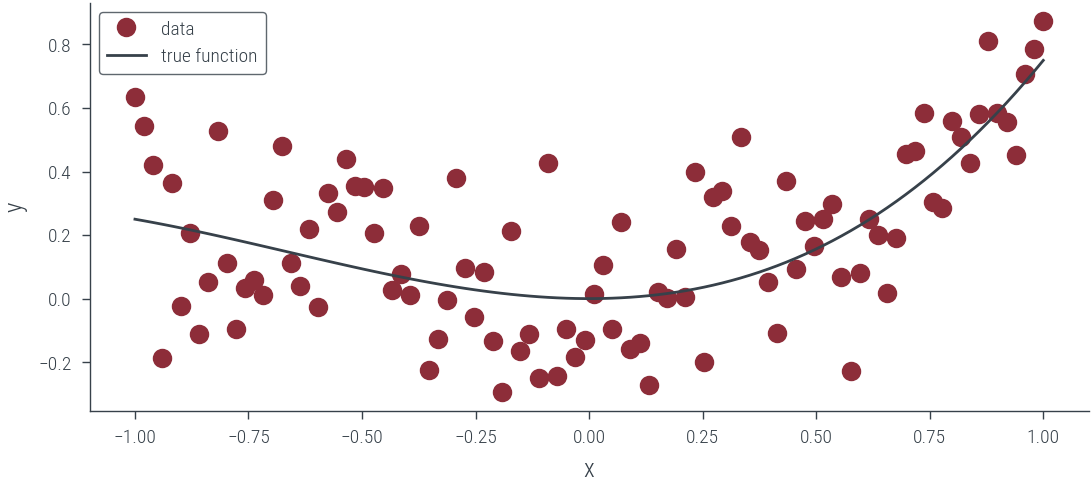

In [4]:
# Plot data and true function
plt.plot(x_lin.cpu(), y.cpu(), "o", label="data")
plt.plot(x_lin.cpu(), f(x_lin).cpu(), label="true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()


In [5]:
#### Case 1.1 NN with homoskedastic noise


class HomoskedasticNNFixedNoise(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        mu_hat = self.fc3(x)
        return mu_hat


In [6]:
def loss_homoskedastic_fixed_noise(model, x, y, log_noise_std):
    mu_hat = model(x).squeeze()
    assert mu_hat.shape == y.shape
    noise_std = torch.exp(log_noise_std).expand_as(mu_hat)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).mean()


In [7]:
model_1 = HomoskedasticNNFixedNoise()
# Move to GPU
model_1.to(device)

HomoskedasticNNFixedNoise(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
fixed_log_noise_std = torch.log(torch.tensor(0.5)).to(device)
loss_homoskedastic_fixed_noise(model_1, x_lin[:, None], y, fixed_log_noise_std)

tensor(0.3774, device='cuda:0', grad_fn=<NegBackward0>)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


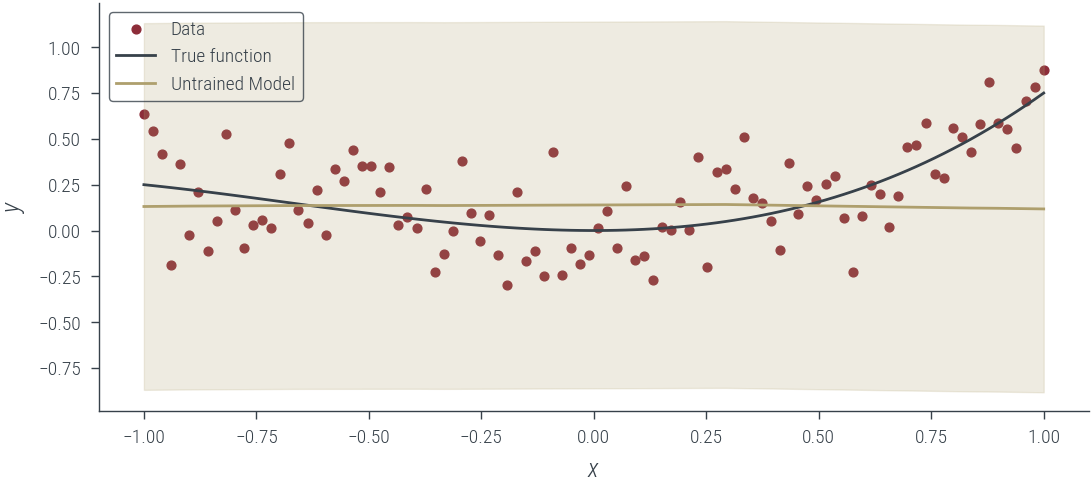

In [9]:
def plot_model_1(
    model, l="Untrained model", log_noise_param=fixed_log_noise_std, aleatoric=True
):
    with torch.no_grad():
        y_hat = model(x_lin[:, None]).squeeze().cpu()
        std = torch.exp(log_noise_param).cpu()

    plt.scatter(x_lin.cpu(), y.cpu(), s=10, color="C0", label="Data")
    plt.plot(x_lin.cpu(), f(x_lin.cpu()), color="C1", label="True function")
    plt.plot(x_lin.cpu(), y_hat.cpu(), color="C2", label=l)
    if aleatoric:
        # Plot the +- 2 sigma region (where sigma is fixed to 0.2)
        plt.fill_between(
            x_lin.cpu(), y_hat - 2 * std, y_hat + 2 * std, alpha=0.2, color="C2"
        )
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend()


plot_model_1(model_1, "Untrained Model")


In [10]:
def train(model, loss_func, params, x, y, log_noise_param, n_epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(params, lr=lr)
    for epoch in range(n_epochs):
        # Print every 10 epochs
        if epoch % 50 == 0:
            noise_std = torch.exp(
                log_noise_param
            )  # Calculate the noise standard deviation
            print(f"Epoch {epoch}: loss {loss_func(model, x, y, log_noise_param)}")
        optimizer.zero_grad()
        loss = loss_func(model, x, y, log_noise_param)
        loss.backward()
        optimizer.step()
    return loss.item()


In [11]:
params = list(model_1.parameters())
train(
    model_1,
    loss_homoskedastic_fixed_noise,
    params,
    x_lin[:, None],
    y,
    fixed_log_noise_std,
    n_epochs=1000,
    lr=0.001,
)


Epoch 0: loss 0.37737852334976196
Epoch 50: loss 0.36576324701309204
Epoch 100: loss 0.36115822196006775
Epoch 150: loss 0.35357466340065
Epoch 200: loss 0.3445783853530884
Epoch 250: loss 0.33561965823173523
Epoch 300: loss 0.3253604769706726
Epoch 350: loss 0.3168313503265381
Epoch 400: loss 0.3112250566482544
Epoch 450: loss 0.30827972292900085
Epoch 500: loss 0.30689162015914917
Epoch 550: loss 0.30621206760406494
Epoch 600: loss 0.3059086203575134
Epoch 650: loss 0.30568134784698486
Epoch 700: loss 0.3052031695842743
Epoch 750: loss 0.305046409368515
Epoch 800: loss 0.30500170588493347
Epoch 850: loss 0.3049851953983307
Epoch 900: loss 0.30497878789901733
Epoch 950: loss 0.3049766719341278


0.3049757182598114

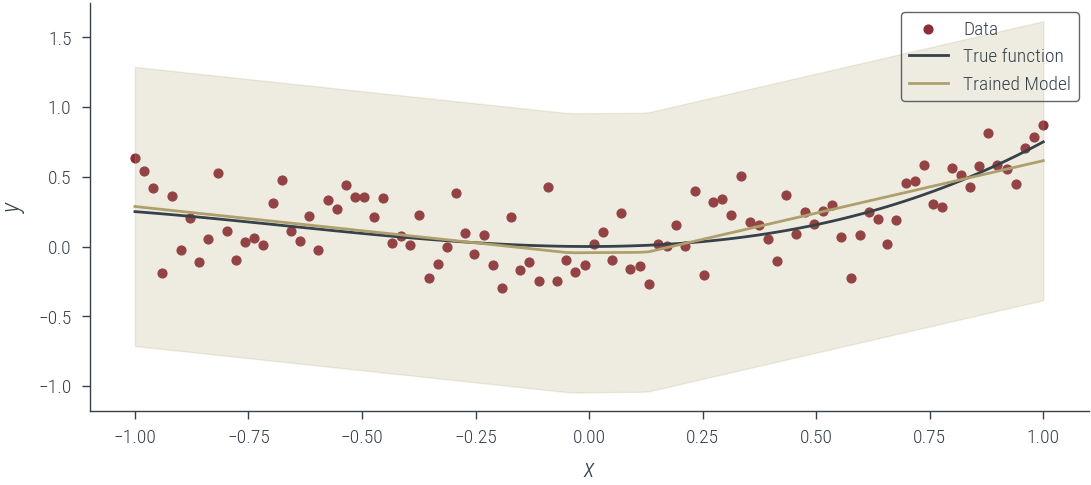

In [12]:
plot_model_1(model_1, "Trained Model")

#### Case 1.2  NN with homoskedastic noise (learned)

The model is the same as in case 1.1, but the noise is learned from the data. Thus, we need to modify the loss function to include the noise parameter $\sigma$.


In [13]:
# Define the loss function
def loss_homoskedastic_learned_noise(model, x, y, noise):
    mean = model(x)
    dist = torch.distributions.Normal(mean, noise)
    return -dist.log_prob(y).mean()

In [14]:
model_2 = HomoskedasticNNFixedNoise()
log_noise_param = torch.nn.Parameter(torch.tensor(0.0).to(device))

# Move to GPU
model_2.to(device)

HomoskedasticNNFixedNoise(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

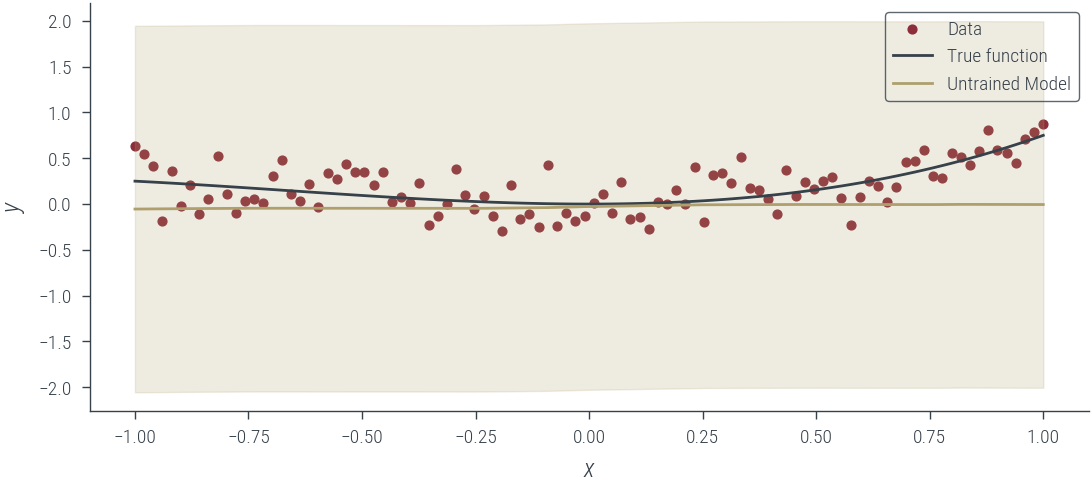

In [15]:
# Plot the untrained model
plot_model_1(model_2, "Untrained Model", log_noise_param=log_noise_param)

In [16]:
# Train the model
params = list(model_2.parameters()) + [log_noise_param]

train(
    model_2,
    loss_homoskedastic_fixed_noise,
    params,
    x_lin[:, None],
    y,
    log_noise_param,
    n_epochs=1000,
    lr=0.01,
)


Epoch 0: loss 0.9752065539360046
Epoch 50: loss 0.4708317220211029
Epoch 100: loss 0.06903044134378433
Epoch 150: loss -0.19027572870254517
Epoch 200: loss -0.31068307161331177
Epoch 250: loss -0.3400699496269226
Epoch 300: loss -0.3422872722148895
Epoch 350: loss -0.3424949049949646
Epoch 400: loss -0.3450787365436554
Epoch 450: loss -0.348661333322525
Epoch 500: loss -0.3499276638031006
Epoch 550: loss -0.34957197308540344
Epoch 600: loss -0.3541718125343323
Epoch 650: loss -0.3527887165546417
Epoch 700: loss -0.3585814833641052
Epoch 750: loss -0.3589327931404114
Epoch 800: loss -0.3592424690723419
Epoch 850: loss -0.3592303693294525
Epoch 900: loss -0.3538239300251007
Epoch 950: loss -0.35970067977905273


-0.3580436110496521

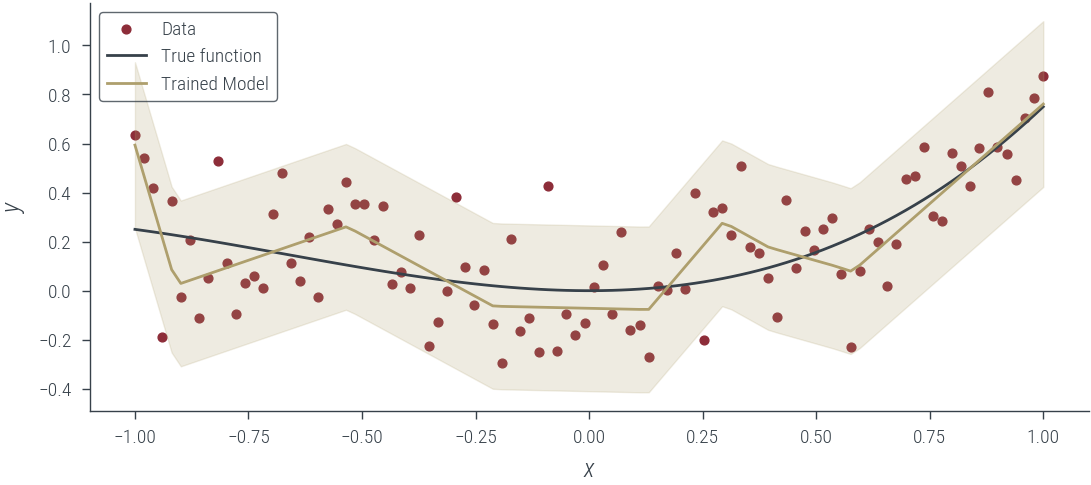

In [17]:
# Plot the trained model
plot_model_1(model_2, "Trained Model", log_noise_param=log_noise_param)

In [18]:
#### Heteroskedastic noise model


class HeteroskedasticNN(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, 2)  # we learn both mu and log_noise_std

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        z = self.fc3(x)
        mu_hat = z[:, 0]
        log_noise_std = z[:, 1]
        return mu_hat, log_noise_std


In [19]:
model_3 = HeteroskedasticNN()
# Move to GPU
model_3.to(device)


HeteroskedasticNN(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)

In [20]:
def _plot(y_hat, std, l="Untrained model"):
    plt.scatter(x_lin.cpu(), y.cpu(), s=10, color="C0", label="Data")
    plt.plot(x_lin.cpu(), f(x_lin.cpu()), color="C1", label="True function")
    plt.plot(x_lin.cpu(), y_hat.cpu(), color="C2", label=l)
    # Plot the +- 2 sigma region (where sigma is fixed to 0.2)
    plt.fill_between(
        x_lin.cpu(), y_hat - 2 * std, y_hat + 2 * std, alpha=0.2, color="C2"
    )
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend()


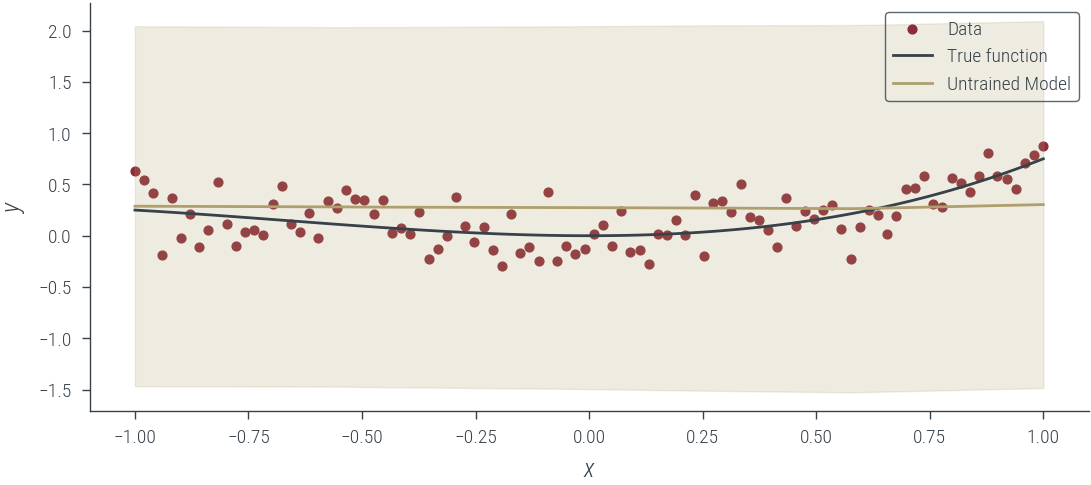

In [21]:
def plot_heteroskedastic_model(
    model, l="Untrained model", log_noise_param=fixed_log_noise_std
):
    with torch.no_grad():
        y_hat, log_noise_std = model(x_lin[:, None])
        std = torch.exp(log_noise_std).cpu()
        y_hat = y_hat.cpu()

    _plot(y_hat, std, l)


plot_heteroskedastic_model(model_3, "Untrained Model")


In [22]:
# Train
params = list(model_3.parameters())


def loss_heteroskedastic(model, x, y):
    mu_hat, log_noise_std = model(x)
    noise_std = torch.exp(log_noise_std)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).mean()


def train_heteroskedastic(model, loss_func, params, x, y, n_epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(params, lr=lr)
    for epoch in range(n_epochs):
        # Print every 10 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: loss {loss_func(model, x, y)}")
        optimizer.zero_grad()
        loss = loss_func(model, x, y)
        loss.backward()
        optimizer.step()
    return loss.item()


train_heteroskedastic(
    model_3, loss_heteroskedastic, params, x_lin[:, None], y, n_epochs=1000, lr=0.001
)


Epoch 0: loss 0.8471216559410095
Epoch 50: loss 0.5730974674224854
Epoch 100: loss 0.21664416790008545
Epoch 150: loss -0.0901612937450409
Epoch 200: loss -0.18870659172534943
Epoch 250: loss -0.21993499994277954
Epoch 300: loss -0.23635315895080566
Epoch 350: loss -0.24628539383411407
Epoch 400: loss -0.2610110640525818
Epoch 450: loss -0.2744489908218384
Epoch 500: loss -0.28417855501174927
Epoch 550: loss -0.29257726669311523
Epoch 600: loss -0.30057546496391296
Epoch 650: loss -0.3061988353729248
Epoch 700: loss -0.31035324931144714
Epoch 750: loss -0.3138866126537323
Epoch 800: loss -0.3167155683040619
Epoch 850: loss -0.3188284635543823
Epoch 900: loss -0.32069918513298035
Epoch 950: loss -0.32232046127319336


-0.323951780796051

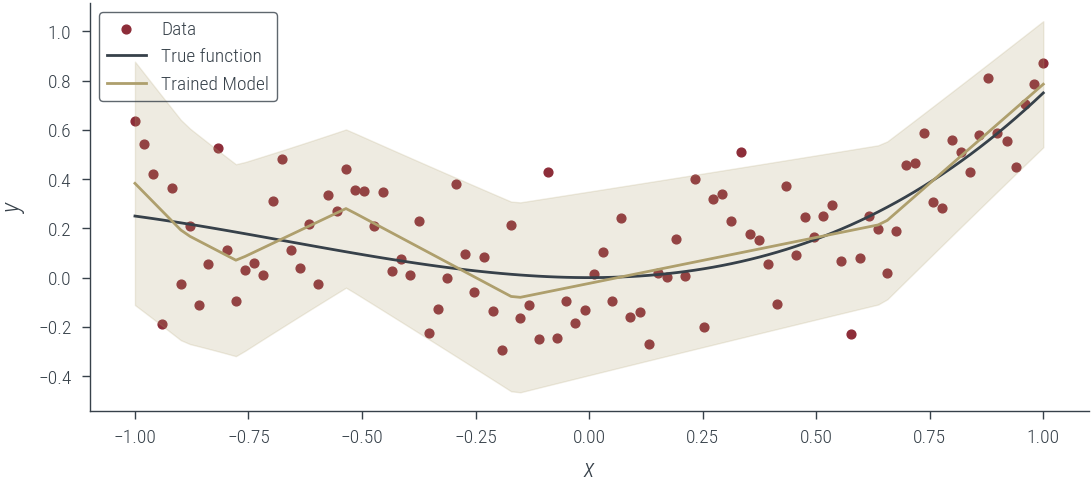

In [23]:
# Plot the trained model
plot_heteroskedastic_model(model_3, "Trained Model")

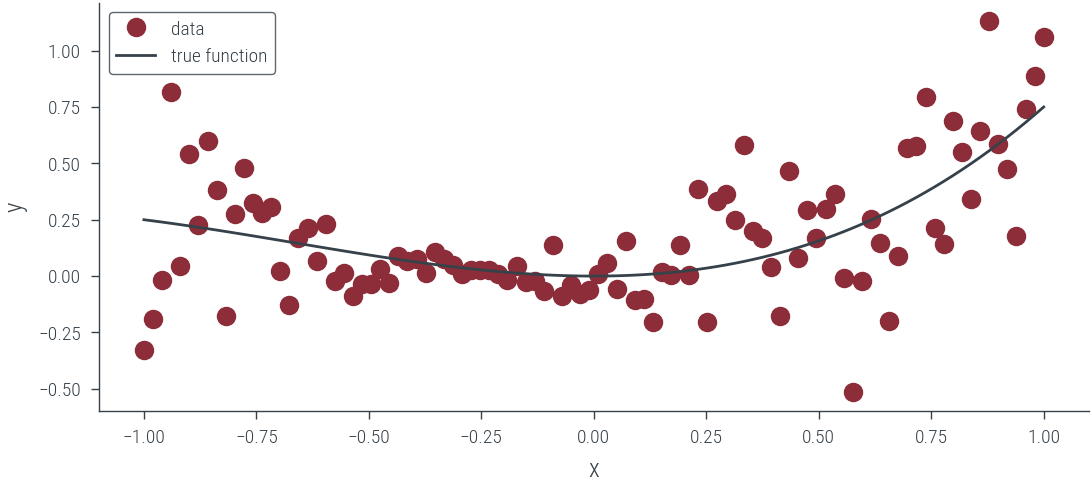

In [24]:
# Now, let us try these on some data that is not homoskedastic

# Generate data

torch.manual_seed(42)
N = 100
x_lin = torch.linspace(-1, 1, N)

f = lambda x: 0.5 * x**2 + 0.25 * x**3

eps = torch.randn(N) * (0.1 + 0.4 * x_lin)

y = f(x_lin) + eps

# Move to GPU
x_lin = x_lin.to(device)
y = y.to(device)

# Plot data and true function
plt.plot(x_lin.cpu(), y.cpu(), "o", label="data")
plt.plot(x_lin.cpu(), f(x_lin).cpu(), label="true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()


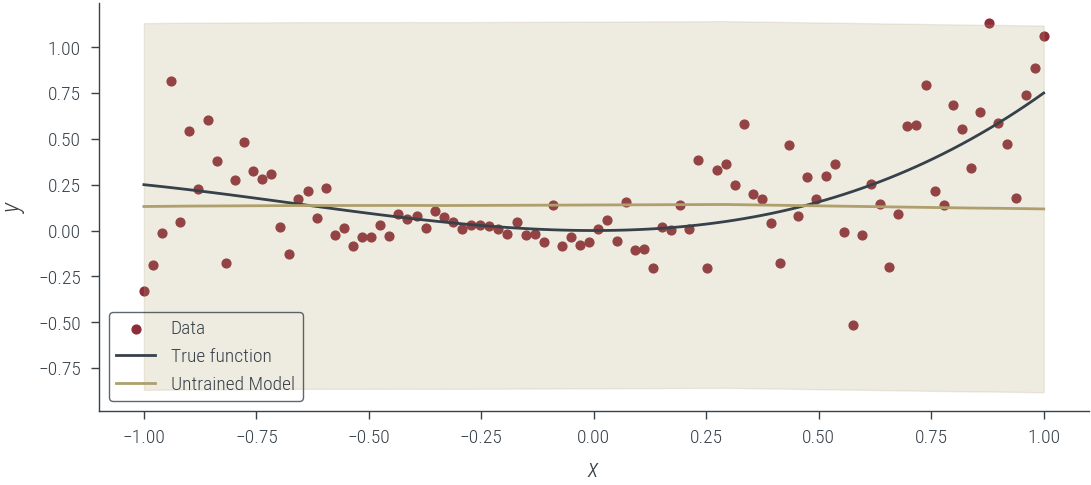

In [25]:
# Now, fit the homoskedastic model

model_4 = HomoskedasticNNFixedNoise()
# Move to GPU
model_4.to(device)

fixed_log_noise_std = torch.log(torch.tensor(0.5)).to(device)

# Plot the untrained model
plot_model_1(model_4, "Untrained Model", log_noise_param=fixed_log_noise_std)

# Train the model
params = list(model_4.parameters())

Epoch 0: loss 0.4041783809661865
Epoch 50: loss 0.3925568163394928
Epoch 100: loss 0.38583633303642273
Epoch 150: loss 0.3760771155357361
Epoch 200: loss 0.3653101623058319
Epoch 250: loss 0.3552305996417999
Epoch 300: loss 0.3461504280567169
Epoch 350: loss 0.3392468988895416
Epoch 400: loss 0.33482256531715393
Epoch 450: loss 0.3323317766189575
Epoch 500: loss 0.3309779167175293
Epoch 550: loss 0.3298887312412262
Epoch 600: loss 0.3292028307914734
Epoch 650: loss 0.32881179451942444
Epoch 700: loss 0.3285224139690399
Epoch 750: loss 0.3282739520072937
Epoch 800: loss 0.32803454995155334
Epoch 850: loss 0.32778945565223694
Epoch 900: loss 0.3275414705276489
Epoch 950: loss 0.3272767663002014


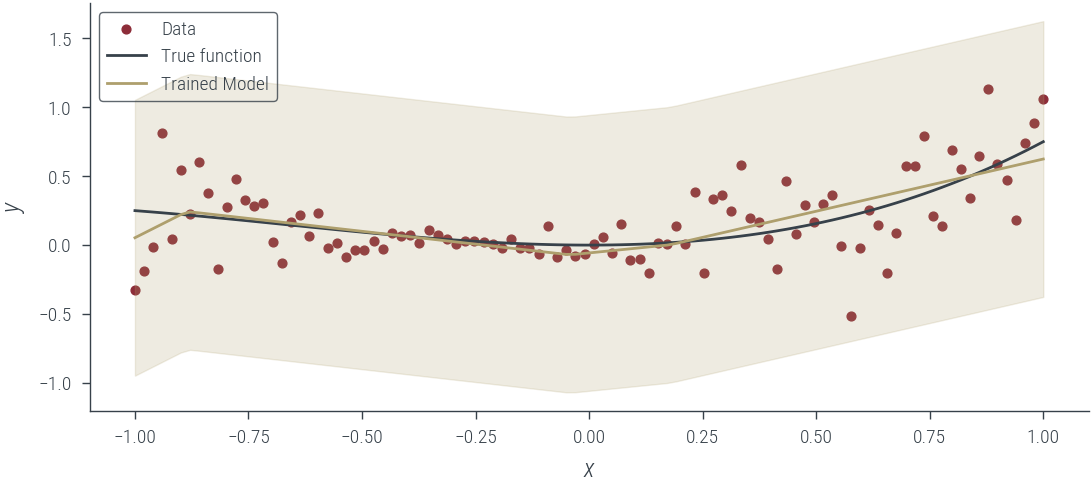

In [26]:
train(
    model_4,
    loss_homoskedastic_fixed_noise,
    params,
    x_lin[:, None],
    y,
    fixed_log_noise_std,
    n_epochs=1000,
    lr=0.001,
)

# Plot the trained model
plot_model_1(model_4, "Trained Model", log_noise_param=fixed_log_noise_std)


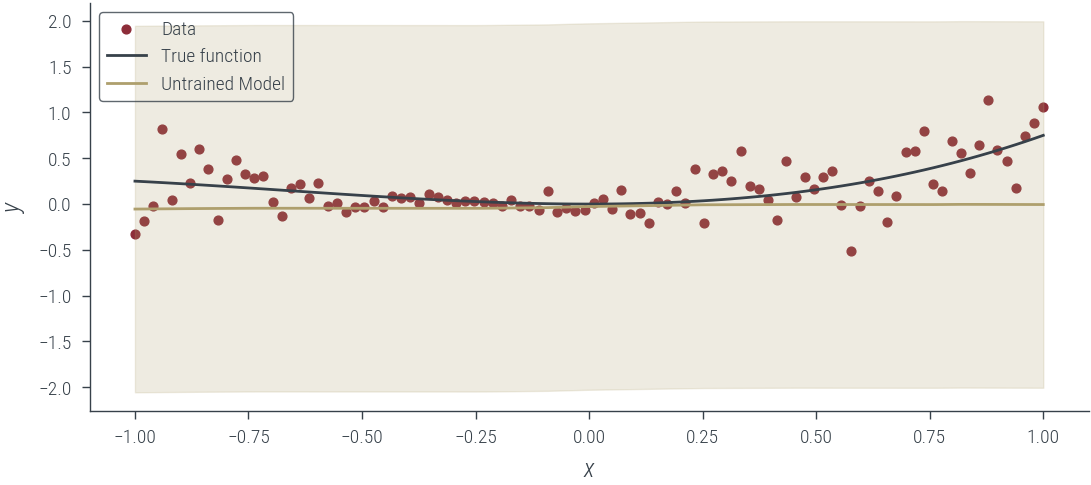

In [27]:
# Now, fit the homoskedastic model with learned noise

model_5 = HomoskedasticNNFixedNoise()
log_noise_param = torch.nn.Parameter(torch.tensor(0.0).to(device))

# Move to GPU
model_5.to(device)

# Plot the untrained model
plot_model_1(model_5, "Untrained Model", log_noise_param=log_noise_param)


Epoch 0: loss 0.9799039959907532
Epoch 50: loss 0.487409383058548
Epoch 100: loss 0.10527730733156204
Epoch 150: loss -0.13744640350341797
Epoch 200: loss -0.225139319896698
Epoch 250: loss -0.24497787654399872
Epoch 300: loss -0.24193085730075836
Epoch 350: loss -0.2481481432914734
Epoch 400: loss -0.2538861632347107
Epoch 450: loss -0.25253206491470337
Epoch 500: loss -0.2516896426677704
Epoch 550: loss -0.2537526786327362
Epoch 600: loss -0.25108057260513306
Epoch 650: loss -0.2549664378166199
Epoch 700: loss -0.2547767460346222
Epoch 750: loss -0.25436392426490784
Epoch 800: loss -0.2519540786743164
Epoch 850: loss -0.25377777218818665
Epoch 900: loss -0.2500659227371216
Epoch 950: loss -0.2547629475593567


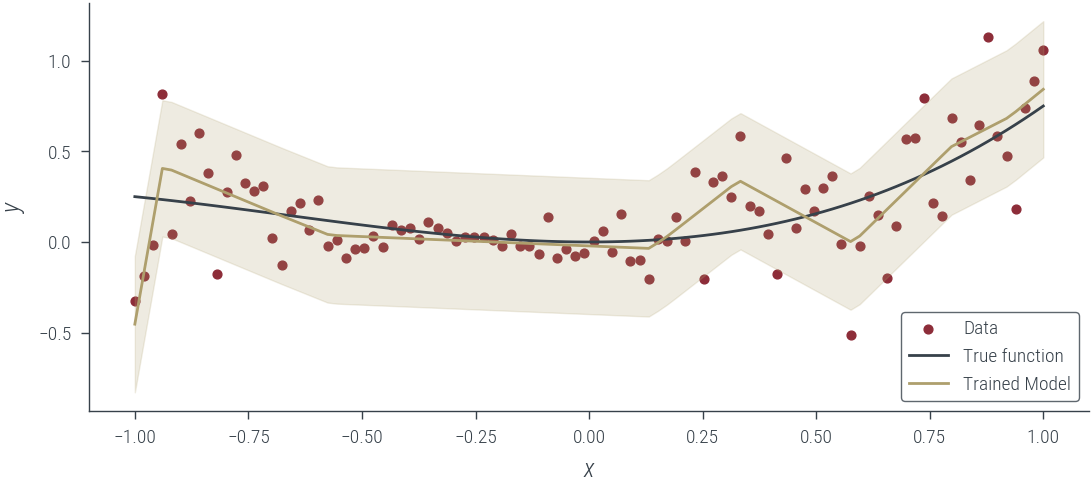

In [28]:
# Train the model
params = list(model_5.parameters()) + [log_noise_param]

train(
    model_5,
    loss_homoskedastic_fixed_noise,
    params,
    x_lin[:, None],
    y,
    log_noise_param,
    n_epochs=1000,
    lr=0.01,
)

# Plot the trained model
plot_model_1(model_5, "Trained Model", log_noise_param=log_noise_param)


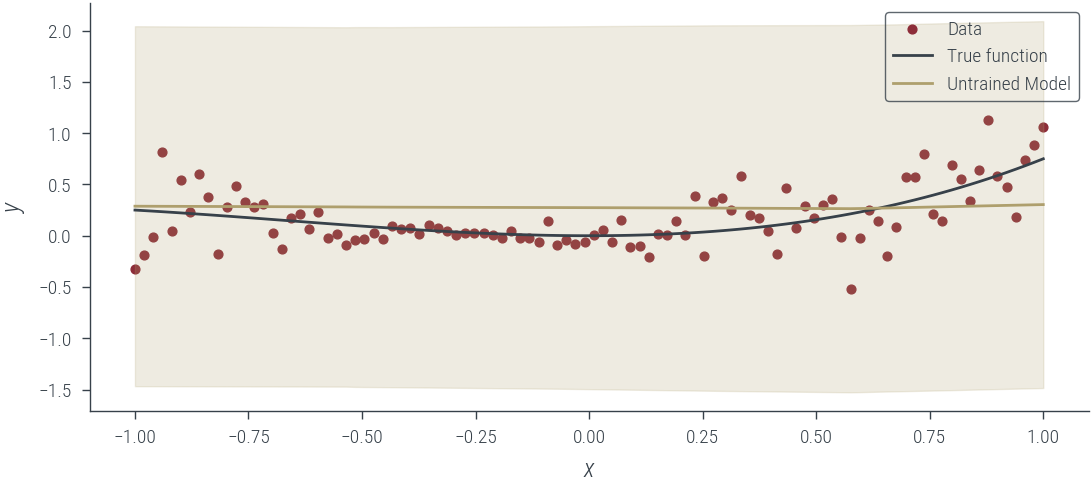

In [29]:
# Now, fit the heteroskedastic model

model_6 = HeteroskedasticNN()
# Move to GPU
model_6.to(device)

# Plot the untrained model
plot_heteroskedastic_model(model_6, "Untrained Model")

In [30]:
# Train the model
params = list(model_6.parameters())

train_heteroskedastic(
    model_6, loss_heteroskedastic, params, x_lin[:, None], y, n_epochs=1000, lr=0.001
)


Epoch 0: loss 0.857245147228241
Epoch 50: loss 0.5856861472129822
Epoch 100: loss 0.24207858741283417
Epoch 150: loss -0.006745247635990381
Epoch 200: loss -0.0828532800078392
Epoch 250: loss -0.13739755749702454
Epoch 300: loss -0.19300477206707
Epoch 350: loss -0.24690848588943481
Epoch 400: loss -0.29788991808891296
Epoch 450: loss -0.33707040548324585
Epoch 500: loss -0.368070513010025
Epoch 550: loss -0.3885715901851654
Epoch 600: loss -0.40538740158081055
Epoch 650: loss -0.4239954948425293
Epoch 700: loss -0.4402863085269928
Epoch 750: loss -0.45339828729629517
Epoch 800: loss -0.46312591433525085
Epoch 850: loss -0.4695749878883362
Epoch 900: loss -0.47566917538642883
Epoch 950: loss -0.4823095500469208


-0.4882388710975647

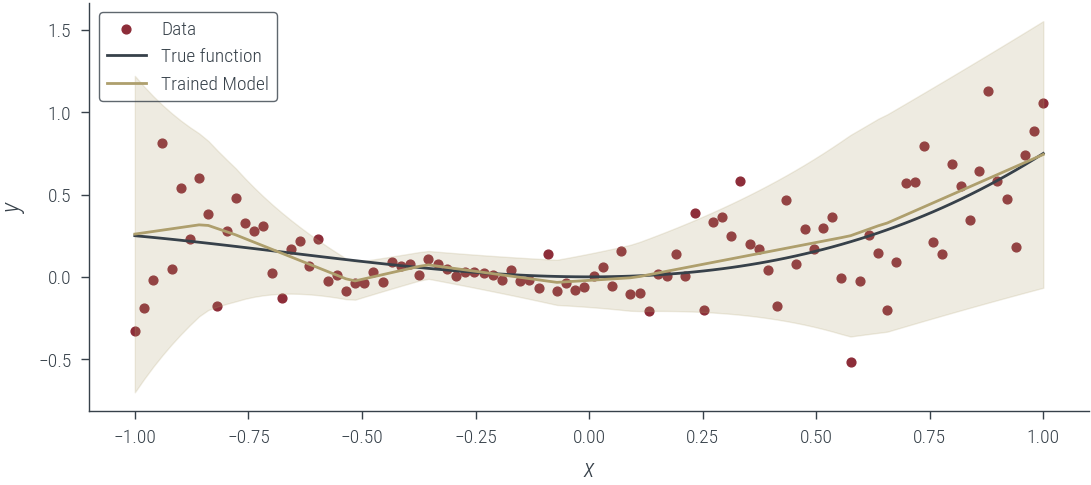

In [31]:
# Plot the trained model
plot_heteroskedastic_model(model_6, "Trained Model")

### Bayesian NN with Laplace approximation

In [149]:
model_7 = HomoskedasticNNFixedNoise()
# Move to GPU
model_7.to(device)


def negative_log_prior_last_layer(model):
    log_prior = torch.distributions.Normal(0, 1).log_prob(model.fc3.weight).sum()
    return -log_prior


def negative_log_prior(model):
    log_prior = 0

    for param in model.parameters():
        log_prior += torch.distributions.Normal(0, 1).log_prob(param).sum()
    return -log_prior


def negative_log_likelihood(model, x, y, log_noise_std):
    mu_hat = model(x).squeeze()
    assert mu_hat.shape == y.shape
    noise_std = torch.exp(log_noise_std).expand_as(mu_hat)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).sum()


def negative_log_joint(model, x, y, log_noise_std):
    return negative_log_likelihood(model, x, y, log_noise_std) + negative_log_prior(
        model
    )


def negative_log_joint_last_layer(model, x, y, log_noise_std):
    return negative_log_likelihood(
        model, x, y, log_noise_std
    ) + negative_log_prior_last_layer(model)


In [150]:
negative_log_prior(model_7), negative_log_prior_last_layer(model_7)

(tensor(134.4620, device='cuda:0', grad_fn=<NegBackward0>),
 tensor(9.3075, device='cuda:0', grad_fn=<NegBackward0>))

In [151]:
negative_log_likelihood(model_7, x_lin[:, None], y, fixed_log_noise_std)

tensor(39.7739, device='cuda:0', grad_fn=<NegBackward0>)

In [152]:
negative_log_joint(
    model_7, x_lin[:, None], y, fixed_log_noise_std
), negative_log_joint_last_layer(model_7, x_lin[:, None], y, fixed_log_noise_std)


(tensor(174.2360, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(49.0814, device='cuda:0', grad_fn=<AddBackward0>))

In [153]:
# Find the MAP estimate
params = list(model_7.parameters())

train(
    model_7,
    negative_log_joint_last_layer,
    params,
    x_lin[:, None],
    y,
    fixed_log_noise_std,
    n_epochs=1000,
    lr=0.01,
)


Epoch 0: loss 49.08140182495117
Epoch 50: loss 41.87004089355469
Epoch 100: loss 41.60041809082031
Epoch 150: loss 41.5150146484375
Epoch 200: loss 41.46382141113281
Epoch 250: loss 41.397552490234375
Epoch 300: loss 41.356048583984375
Epoch 350: loss 41.324222564697266
Epoch 400: loss 41.2700080871582
Epoch 450: loss 41.220603942871094
Epoch 500: loss 41.18292236328125
Epoch 550: loss 41.12837219238281
Epoch 600: loss 41.083805084228516
Epoch 650: loss 41.02949523925781
Epoch 700: loss 40.970924377441406
Epoch 750: loss 40.92750549316406
Epoch 800: loss 40.912620544433594
Epoch 850: loss 40.8787956237793
Epoch 900: loss 40.853702545166016
Epoch 950: loss 40.8287353515625


40.85931396484375

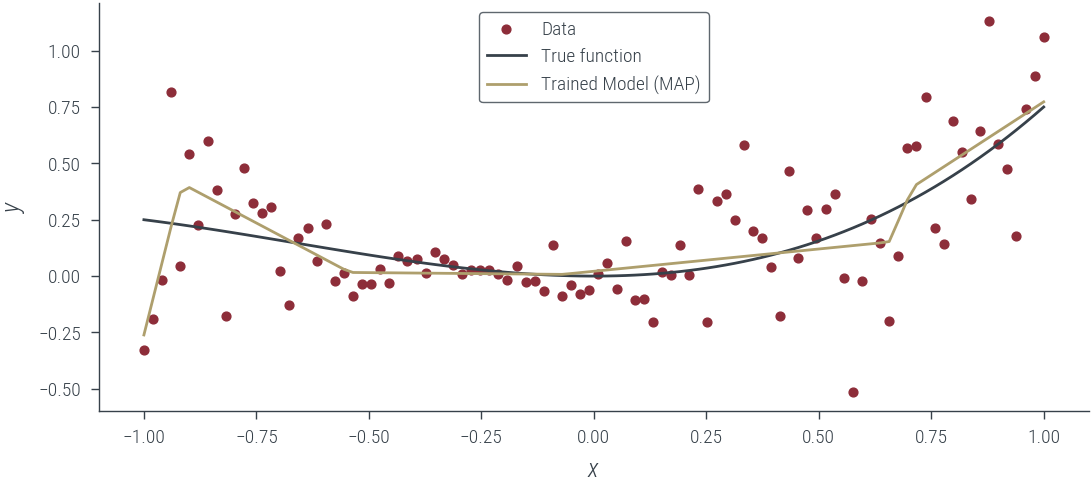

In [136]:
# Plot the trained model (MAP)
plot_model_1(
    model_7, "Trained Model (MAP)", log_noise_param=fixed_log_noise_std, aleatoric=False
)


In [154]:
from functools import partial


def functional_last_layer_neg_log_prior(last_layer_weights):
    log_prior = torch.distributions.Normal(0, 1).log_prob(last_layer_weights).sum()
    return -log_prior


def functional_neg_log_likelihood(state_dict, model, x, y, log_noise_std):
    out = torch.func.functional_call(model, state_dict, x)
    mu_hat = out.squeeze()
    assert mu_hat.shape == y.shape

    noise_std = torch.exp(log_noise_std).expand_as(mu_hat)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).sum()


def functional_last_layer_neg_log_joint(
    last_layer_weights, state_dict, model, x, y, log_noise_std
):
    state_dict["fc3.weight"] = last_layer_weights
    return functional_neg_log_likelihood(
        state_dict, model, x, y, log_noise_std
    ) + functional_last_layer_neg_log_prior(last_layer_weights)

In [155]:
state_dict = model_7.state_dict()
last_layer_weights = state_dict["fc3.weight"]

partial_func = partial(
    functional_last_layer_neg_log_joint,
    state_dict=state_dict,
    model=model_7,
    x=x_lin[:, None],
    y=y,
    log_noise_std=fixed_log_noise_std,
)

H = torch.func.hessian(partial_func)(last_layer_weights)
print(H.shape)

H = H[0, :, 0, :]
print(H.shape)

torch.Size([1, 10, 1, 10])
torch.Size([10, 10])


In [156]:
cov = torch.inverse(H)
laplace_posterior = torch.distributions.MultivariateNormal(
    last_layer_weights.ravel(), cov
)
last_layer_weights_samples = laplace_posterior.sample((101,))[..., None]
last_layer_weights_samples.shape

torch.Size([101, 10, 1])

In [157]:
state_dict["fc3.weight"].shape, last_layer_weights_samples[0].shape, x_lin[
    :, None
].shape


(torch.Size([1, 10]), torch.Size([10, 1]), torch.Size([100, 1]))

In [158]:
def forward_pass(last_layer_weight):
    state_dict = model_7.state_dict()
    state_dict["fc3.weight"] = last_layer_weight.reshape(1, -1)
    return torch.func.functional_call(model_7, state_dict, x_lin[:, None]).squeeze()


forward_pass(last_layer_weights_samples[0]).shape


torch.Size([100])

In [159]:
mc_outputs = torch.vmap(forward_pass)(last_layer_weights_samples)
print(mc_outputs.shape)

torch.Size([101, 100])


In [160]:
mean_mc_outputs = mc_outputs.mean(0)
std_mc_outputs = mc_outputs.std(0)
mean_mc_outputs.shape, std_mc_outputs.shape

(torch.Size([100]), torch.Size([100]))

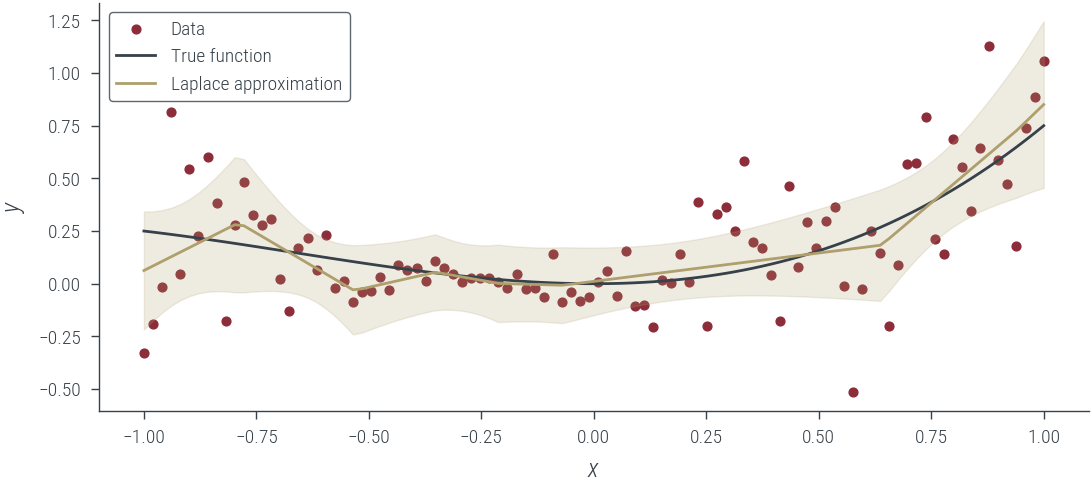

In [161]:
with torch.no_grad():
    plt.scatter(x_lin.cpu(), y.cpu(), s=10, color="C0", label="Data")
    plt.plot(x_lin.cpu(), f(x_lin.cpu()), color="C1", label="True function")
    plt.plot(
        x_lin.cpu(), mean_mc_outputs.cpu(), color="C2", label="Laplace approximation"
    )
    # Plot the +- 2 sigma region (where sigma is fixed to 0.2)
    plt.fill_between(
        x_lin.cpu(),
        mean_mc_outputs.cpu() - 2 * std_mc_outputs.cpu(),
        mean_mc_outputs.cpu() + 2 * std_mc_outputs.cpu(),
        alpha=0.2,
        color="C2",
    )
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend()
